# Binary Classification Code

## Preparation

### Library Preparation

In [ ]:
import numpy as np 
import matplotlib.pyplot as plt 
import pandas as pd
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, f1_score

import tensorflow as tf
from tensorflow.keras.callbacks import Callback, ModelCheckpoint, ReduceLROnPlateau, CSVLogger
from tensorflow.keras.metrics import Precision, Recall, F1Score, AUC
from tensorflow.keras.optimizers import Adam
import tensorflow_datasets as tfds

import os
from IPython.display import FileLink

from dataset_builder import BinaryTomatoLeafDiseaseDataset, QuinaryTomatoLeafDiseaseDataset, MainTomatoLeafDiseaseDataset
from utils import one_hot_encode, preprocess, augment, split_data, predict
from plots import plot_confusion_matrix, plot_learning_rate, plot_training_log, dual_plot_training_log

import warnings
warnings.filterwarnings('ignore')
%config InlineBackend.figure_format = "retina"

### Directory Preparation

In [ ]:
TFDS_DIR = './tfds/'
MODEL_DIR = './models/'
LOG_DIR = './logs/'
OUTPUT_DIR = './images/'

os.environ['TFDS_DATA_DIR'] = TFDS_DIR

for dir in [MODEL_DIR, LOG_DIR, TFDS_DIR, OUTPUT_DIR]:
    if not os.path.exists(dir):
        os.makedirs(dir)

### Data Preparation

In [3]:
builder = MainTomatoLeafDiseaseDataset()
builder.download_and_prepare(download_dir=None)  # No download needed, just prepares paths
num_classes = builder.info.features['label'].num_classes
class_names = builder._get_label_names()
ds = builder.as_dataset(split='train', as_supervised=True)
num_classes, class_names

(10,
 ['bacterial_spot',
  'early_blight',
  'healthy',
  'late_blight',
  'leaf_mold',
  'mosaic_virus',
  'septoria_leaf_spot',
  'spider_mite',
  'target_spot',
  'yellow_leaf_curl_virus'])

### Data Splitting

In [ ]:
ds = ds.map(lambda image, label: one_hot_encode(image, label, num_classes))
train_ds, val_ds, test_ds = split_data(ds, is_binary=False, class_names=class_names)
# del ds

(18160, 256, 256, 3) (18160, 10)

Overall Split Sizes:
Train set shape: (12712, 256, 256, 3), (12712, 10)
Validation set shape: (2724, 256, 256, 3), (2724, 10)
Test set shape: (2724, 256, 256, 3), (2724, 10)

Class distribution data has been saved to: f:\Kuliah\Pembelajaran Mesin dan Kecerdasan Buatan\RBL\SK5004_RBL_10121063_10121089


In [ ]:
class_dist = pd.read_csv(os.path.join(LOG_DIR, 'class_distribution_main.csv'))
class_dist

### Data Preprocessing

In [ ]:
train_ds = train_ds.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)
val_ds = val_ds.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)
test_ds = test_ds.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)

train_ds = train_ds.map(augment, num_parallel_calls=tf.data.AUTOTUNE)

In [ ]:
print("Visualizing augmented training images:")
plt.figure(figsize=(12, 12))
for images, labels in train_ds.take(1): # Take one batch
    for i in range(min(len(images), 16)): # Plot up to 16 images
        ax = plt.subplot(4, 4, i + 1)
        # Ensure the image is in a displayable format (NumPy array, 0-1 range)
        plt.imshow(images[i].numpy())
        # If you have metadata for label names:
        # plt.title(metadata.features['label'].int2str(labels[i].numpy()))
        plt.title(f"Label: {labels[i].numpy()}") # Fallback if no metadata
        plt.axis("off")
plt.tight_layout()
plt.show()

### Data Shuffling, Batching, and Prefetching

In [ ]:
BATCH_SIZE = 32
train_ds = train_ds.shuffle(1000).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

## Model Building

### Model Compilation

In [ ]:
callbacks = [
    ModelCheckpoint(os.path.join(MODEL_DIR, 'best_model_main.keras'), 
                    monitor='val_loss', mode='min', 
                    save_best_only=True, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.95, patience=3, verbose=1),
    CSVLogger(os.path.join(LOG_DIR, 'training_log_main.csv'))
]

class CustomCallback(Callback):
    def on_epoch_end(self, epoch, logs=None):
        print(f'Epoch {epoch} ended. Val Loss: {logs['val_loss']:.4f} | Val F1-Macro: {logs['val_f1_macro']:.4f}')

callbacks.append(CustomCallback())

model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(256, 256, 3)), 
    tf.keras.layers.Conv2D(32, (3, 3), use_bias=False),
    tf.keras.layers.BatchNormalization(),             
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Dropout(rate=0.1), 
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(rate=0.2), 
    tf.keras.layers.Dense(64, use_bias=False),
    tf.keras.layers.BatchNormalization(),             
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.Dropout(rate=0.1), 
    tf.keras.layers.Dense(32, use_bias=False),
    tf.keras.layers.BatchNormalization(),             
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.Dense(10, activation='softmax')
])

model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['categorical_accuracy', 
                       Precision(), Recall(), 
                       F1Score(average=None, name='f1'), 
                       F1Score(average='micro', name='f1_micro'), 
                       F1Score(average='macro', name='f1_macro'), 
                       F1Score(average='weighted', name='f1_weighted'), 
                       AUC()])
model.summary()

### Model Training

In [ ]:
history_obj = model.fit(train_ds, validation_data=val_ds, epochs=100, callbacks=callbacks)
params = history_obj.params
history = history_obj.history
history.tail()

### Model Loading (for easy-use)

In [ ]:
log_path = os.path.join(LOG_DIR, 'training_log_main.csv')
history = pd.read_csv(log_path)
# history.tail()

model_path = os.path.join(MODEL_DIR, 'best_model_main.keras')
model = tf.keras.models.load_model(model_path)
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 254, 254, 32)   │           864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 254, 254, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 254, 254, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 127, 127, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 127, 127, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 31, 31, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 30752)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 30752)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │     1,968,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 10)             │           330 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,915,136 (22.56 MB)

 Trainable params: 1,971,626 (7.52 MB)

 Non-trainable params: 256 (1.00 KB)

 Optimizer params: 3,943,254 (15.04 MB)

### Model Training Log

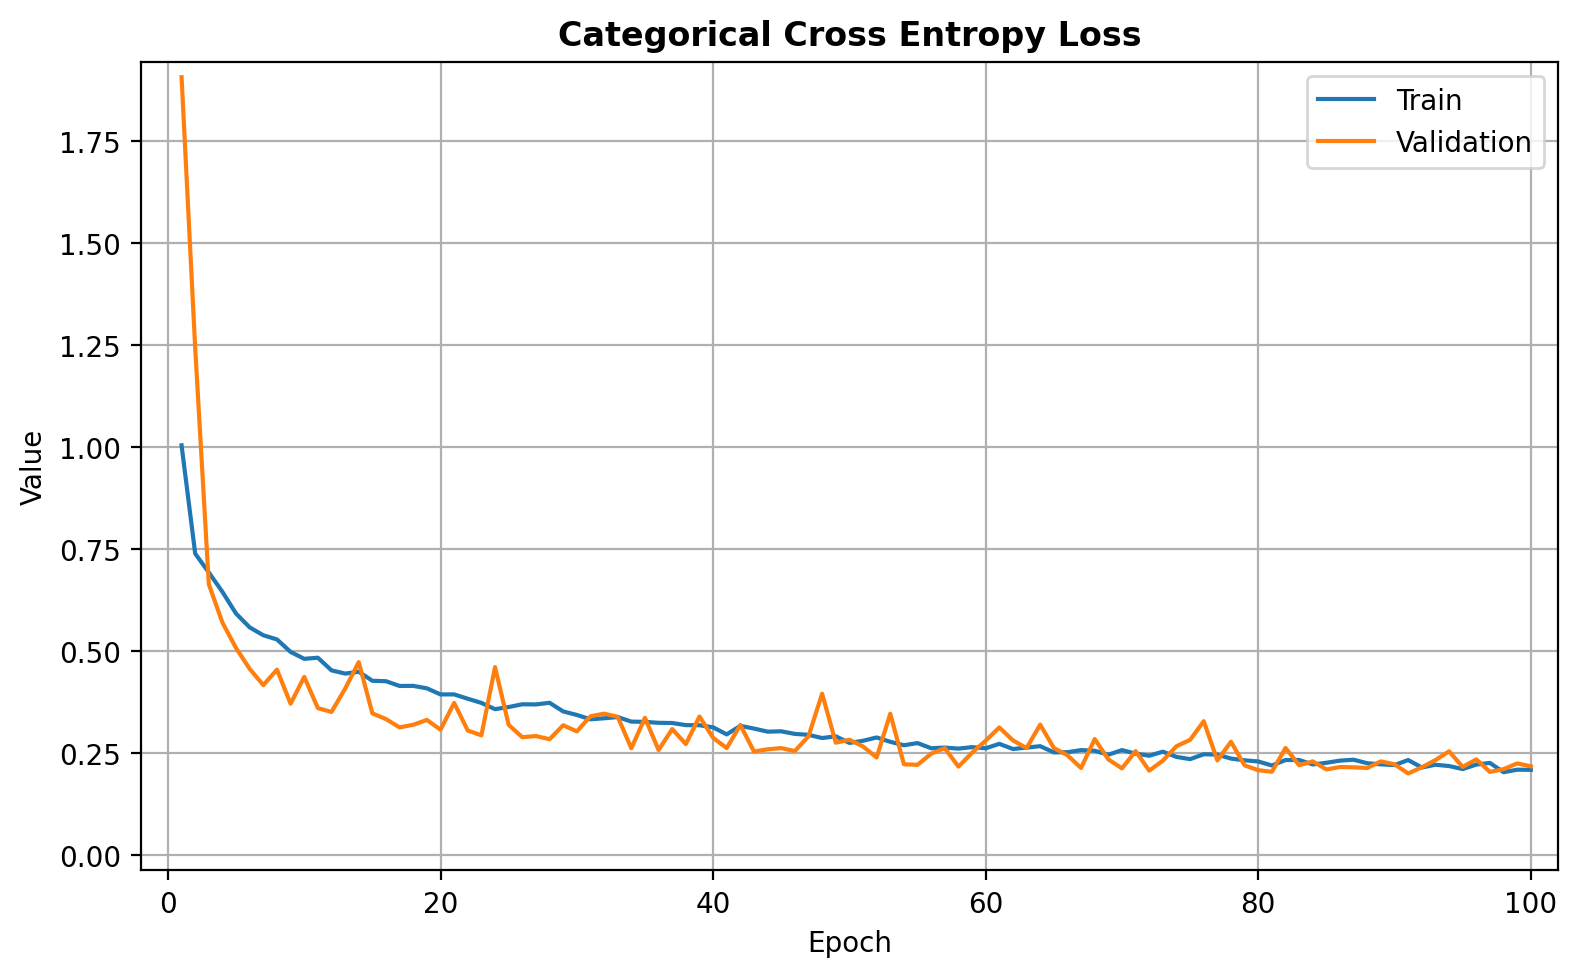

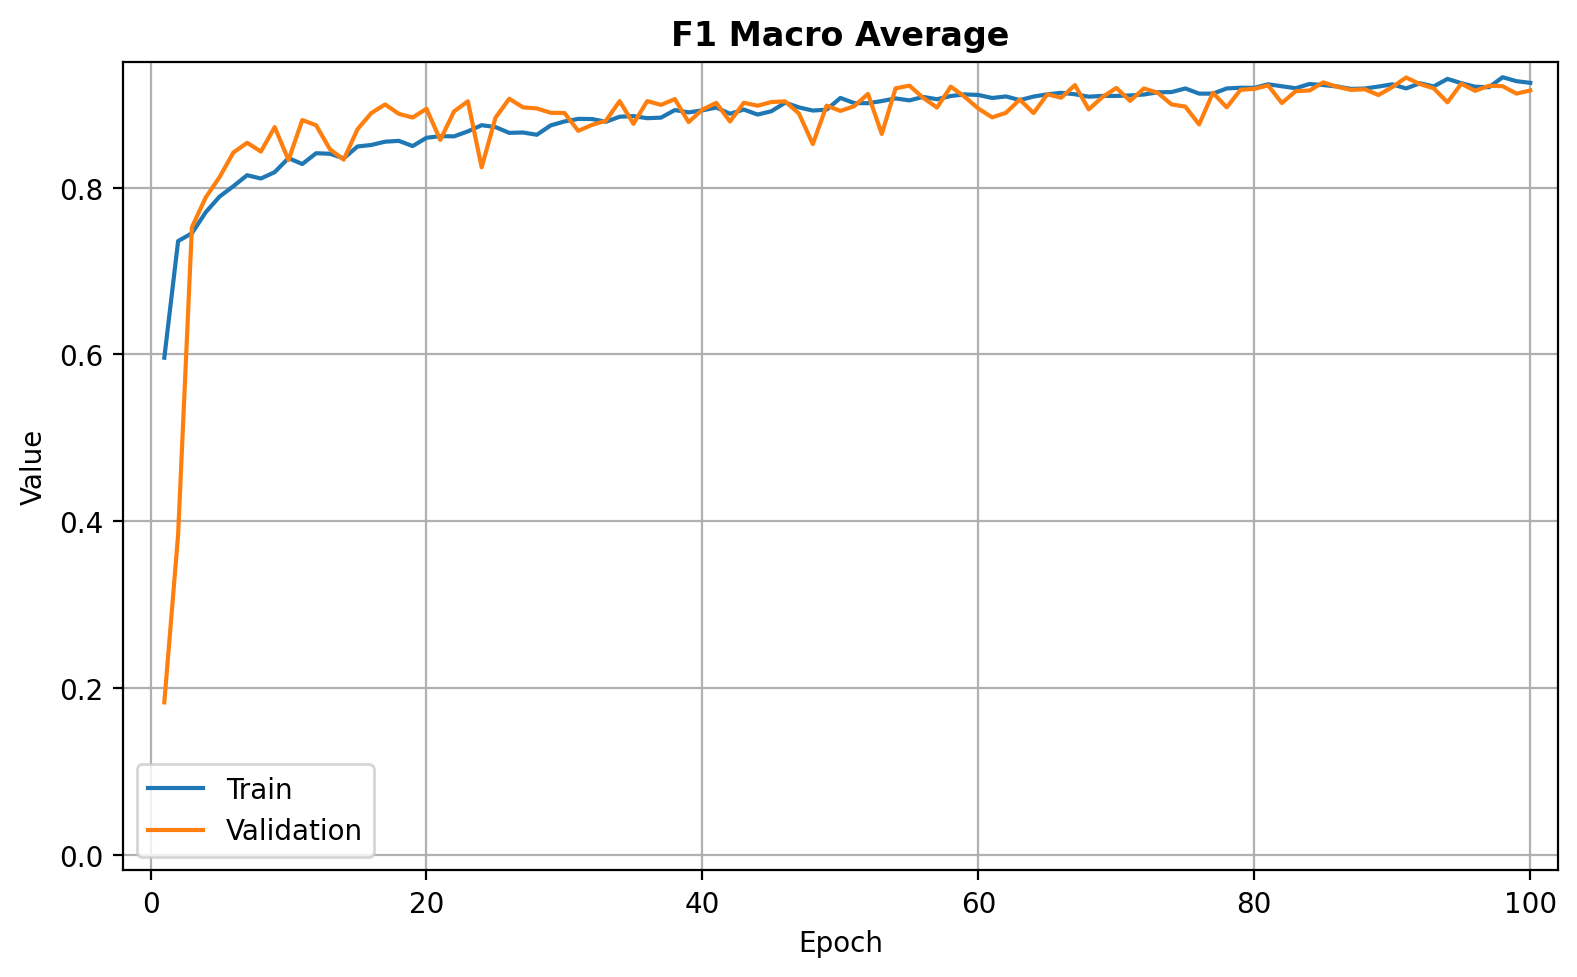

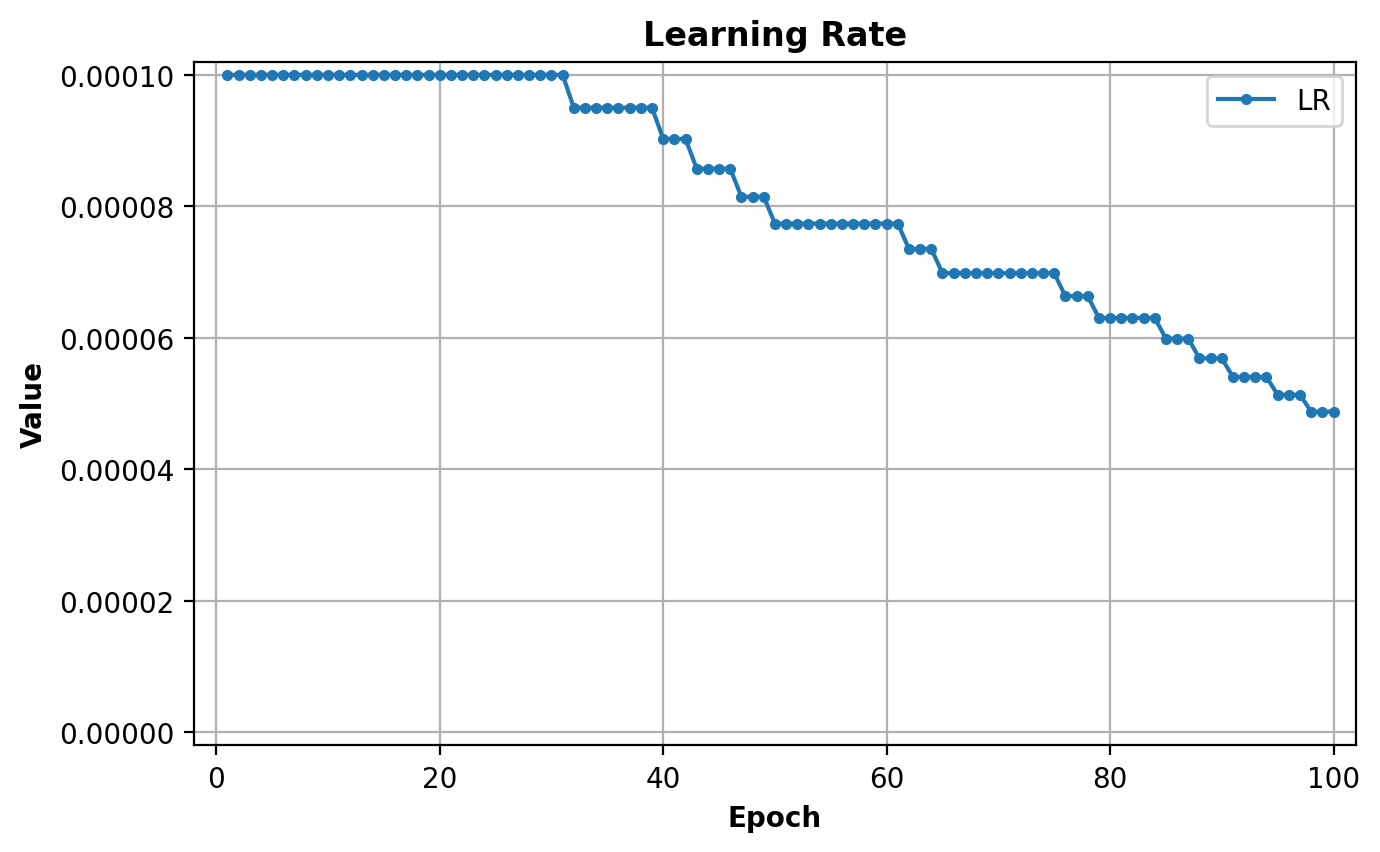

In [ ]:
plot_training_log(history['loss'], history['val_loss'], 'Categorical Cross Entropy Loss', 'loss_main')
plot_training_log(history['f1_macro'], history['val_f1_macro'], 'F1 Macro Average', 'f1_main')
plot_learning_rate(history['learning_rate'], 'Learning Rate', 'lr_main')

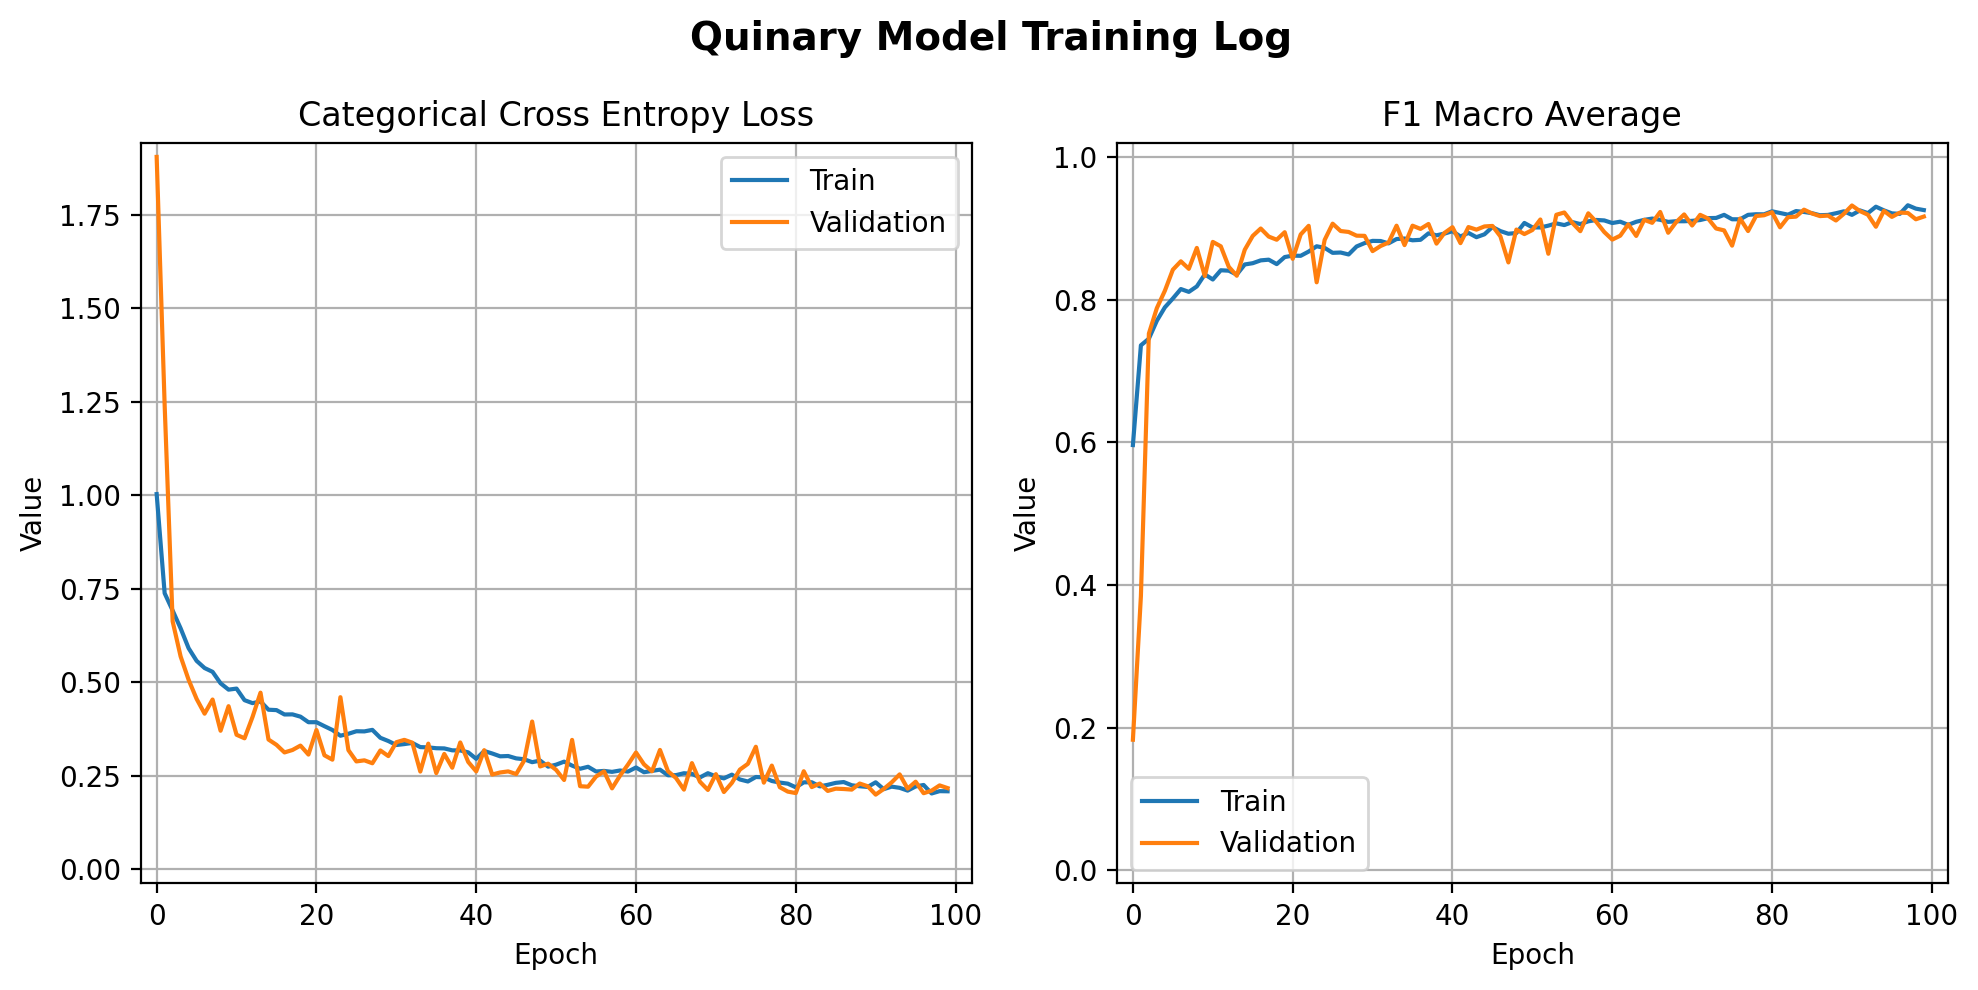

In [ ]:
dual_plot_training_log('main Model Training Log', 'log_main', 
                       history['loss'], history['val_loss'], 'Categorical Cross Entropy Loss', 
                       history['f1_macro'], history['val_f1_macro'], 'F1 Macro Average')

### Model Evaluation

In [15]:
y_true, y_pred = predict(model, test_ds, is_binary=False)

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 298ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 296ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 318ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 373ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 307ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 458ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 483ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 417ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 459ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 437ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 546ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 497ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 424ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 456ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 583ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 527ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 470ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 527ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 615ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 533ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 523ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 492ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 457ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 476ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1

              precision    recall  f1-score   support

    bacteria       0.99      0.98      0.99       319
       fungi       0.97      0.93      0.95       300
     healthy       0.99      0.99      0.99       239
        mite       0.92      0.98      0.95       252
       virus       0.97      0.97      0.97       296

    accuracy                           0.97      1406
   macro avg       0.97      0.97      0.97      1406
weighted avg       0.97      0.97      0.97      1406



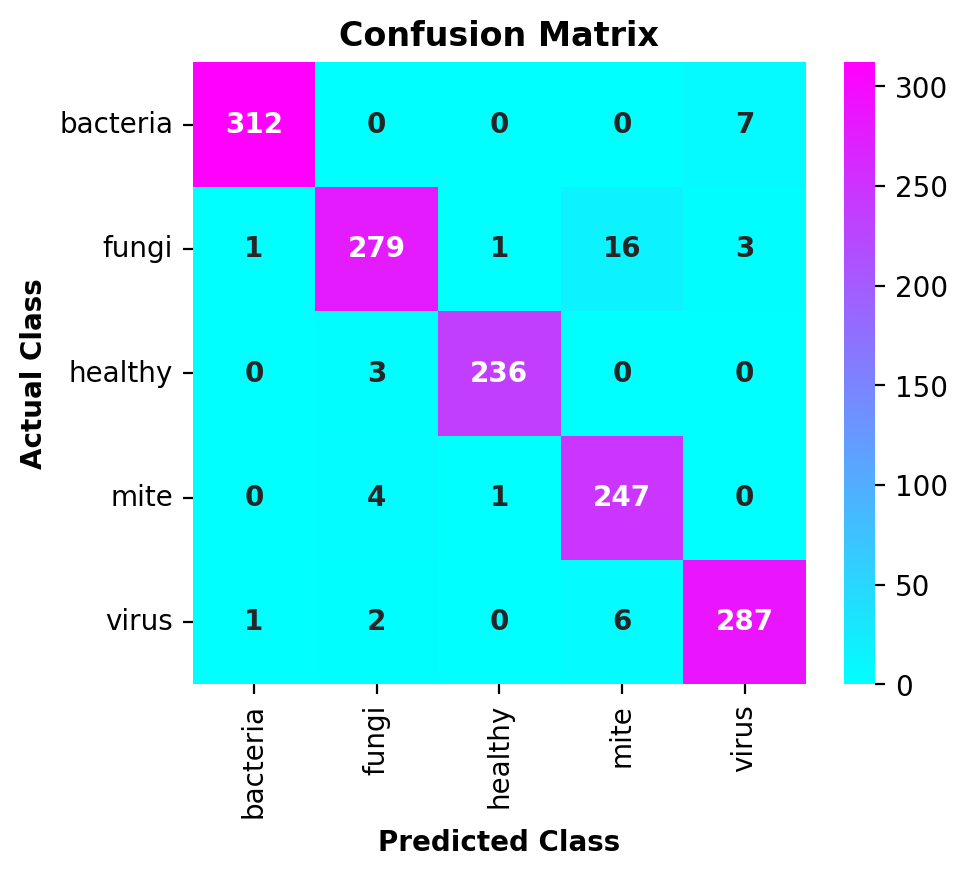

In [ ]:
print(classification_report(y_true, y_pred, target_names=class_names))
cm = confusion_matrix(y_true, y_pred)
plot_confusion_matrix(cm, class_names=class_names, figsize=(5, 4.5), cmap='cool', filename='cm_main')